<center><h1>该文件用于模型预测结果对比(对比预测和标签)用</h1></center>

# 1 准备工作

### 1.1 准备样本

In [1]:
from skimage import io
import random
import numpy as np
imagery = io.imread("../../../dataset/Seglvdi/rgb/rgb.tif")
label = io.imread("../../../dataset/Seglvdi/label/label.tif")

e:\anaconda3\install_path\envs\ddpm-cd\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')
imageSize = 256
number = 50
height = imagery.shape[0]
width = imagery.shape[1]
tree_rate = -1
index = 0
while True:
    UpperLeftX = random.randint(0, height - imageSize)
    UpperLeftY = random.randint(0, width - imageSize)
    labelCrop = label[(UpperLeftX+1): (UpperLeftX + imageSize + 1), (UpperLeftY+1): (UpperLeftY + imageSize + 1)]
    labelCrop[labelCrop > 1] = 1
    tree_rate = np.count_nonzero(labelCrop > 0) / (labelCrop.size)
    # 任意比例乔木含量，都进行预测
    if((tree_rate > 0)): 
        # 符合要求，保存图像
        imgCrop = imagery[UpperLeftX: UpperLeftX + imageSize, UpperLeftY: UpperLeftY + imageSize, 0:3]
        io.imsave("./dataset/rgb/"+str(index)+".tif", imgCrop)
        io.imsave("./dataset/label/"+str(index)+".tif", labelCrop)
        if(index == number):
            break
        index += 1

### 1.2 数据生成器

In [3]:
# 训练图像分割的生成器
from torch.utils.data import Dataset
import torchvision
import torch
from skimage import io
import os
totensor = torchvision.transforms.ToTensor()
#  imageDataRoot路径应该直接指向一张完整的tif影像
#  labelDataRoot路径应该直接指向一张完整的tif标签

class SegImageDataset(Dataset):
    def __init__(self, imageDataRoot,labelDataRoot):
        self.img_paths_folder = imageDataRoot
        self.label_paths_folder = labelDataRoot

        self.img_paths = [] # 图像文件的路径
        self.label_paths = [] # 图像对应的标签

        self.folders =  os.listdir(self.img_paths_folder)
        for folder in self.folders:
            self.img_paths.append(os.path.join(self.img_paths_folder, folder))
            self.label_paths.append(os.path.join(self.label_paths_folder, folder))


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,index):
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        img = io.imread(img_path)
        label = io.imread(label_path)
        label = label.reshape(1,label.shape[0],label.shape[1])
        # 转图片格式
        img = totensor(img)
        label = torch.Tensor(label)
        return (img,label)

### 1.3 加载模型

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = torch.sigmoid(d1)
        return d1

unet = torch.load("../../../model/lvdi/45epoch/epoch_30_lastEpoch_unet_model.pth")
unet.eval()
print("加载完成")

加载完成


# 2 预测并画结果对比

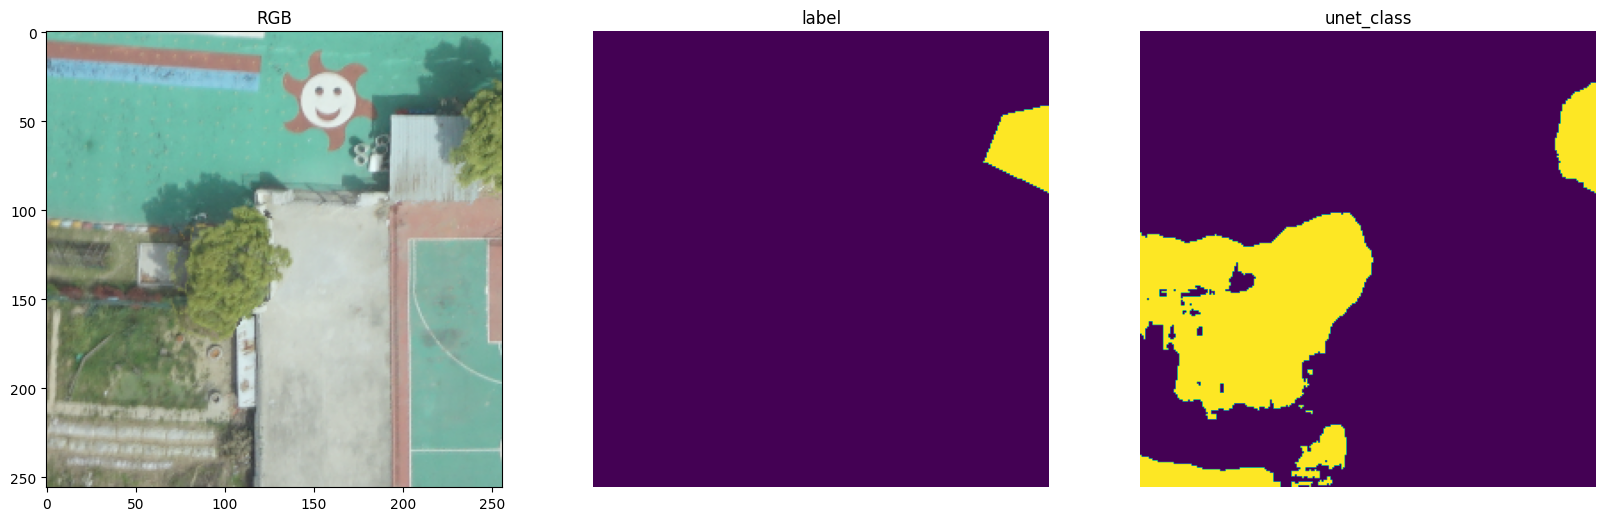

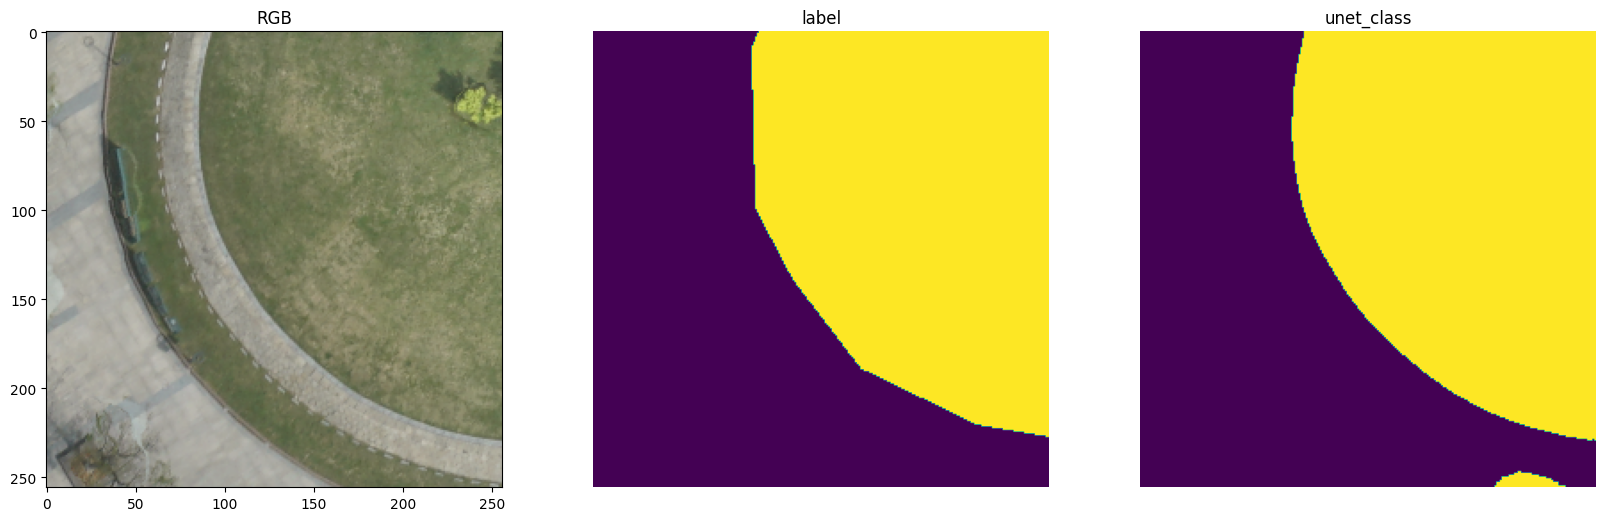

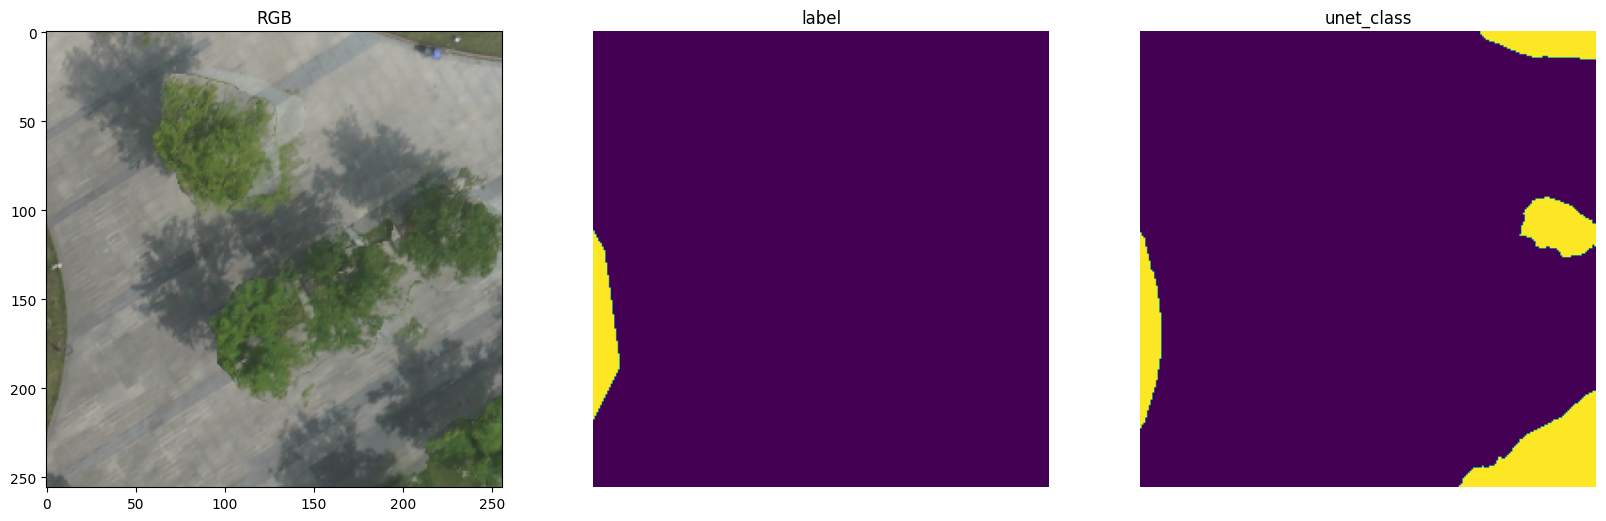

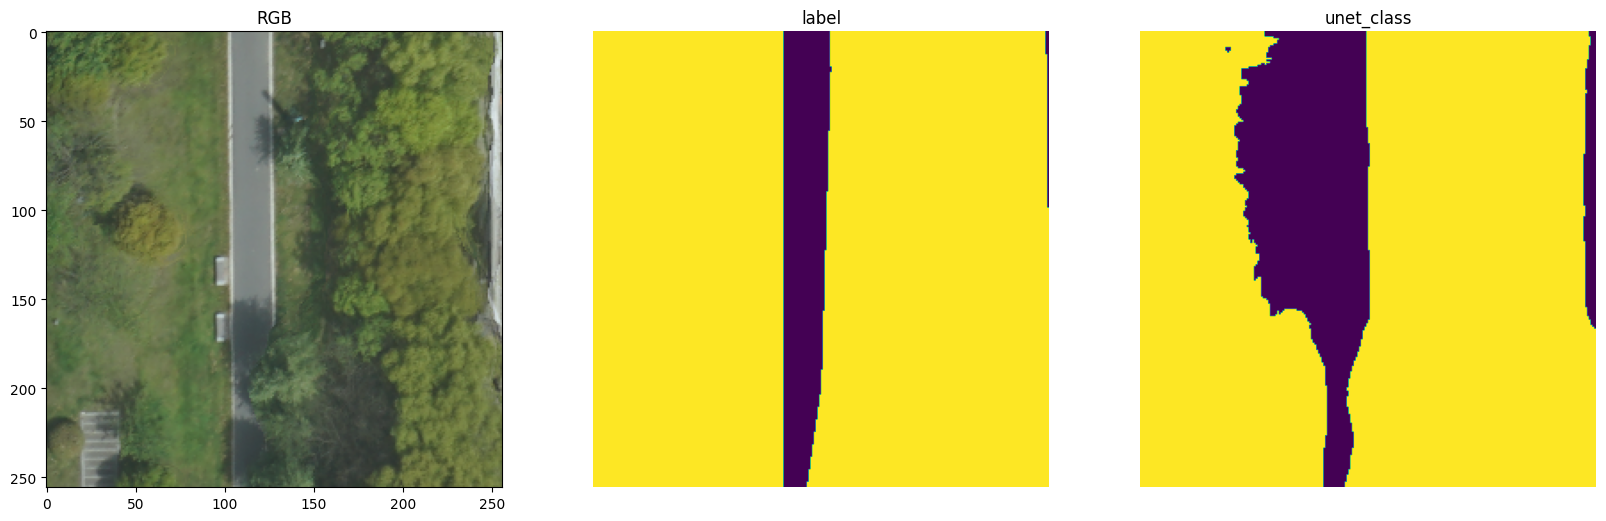

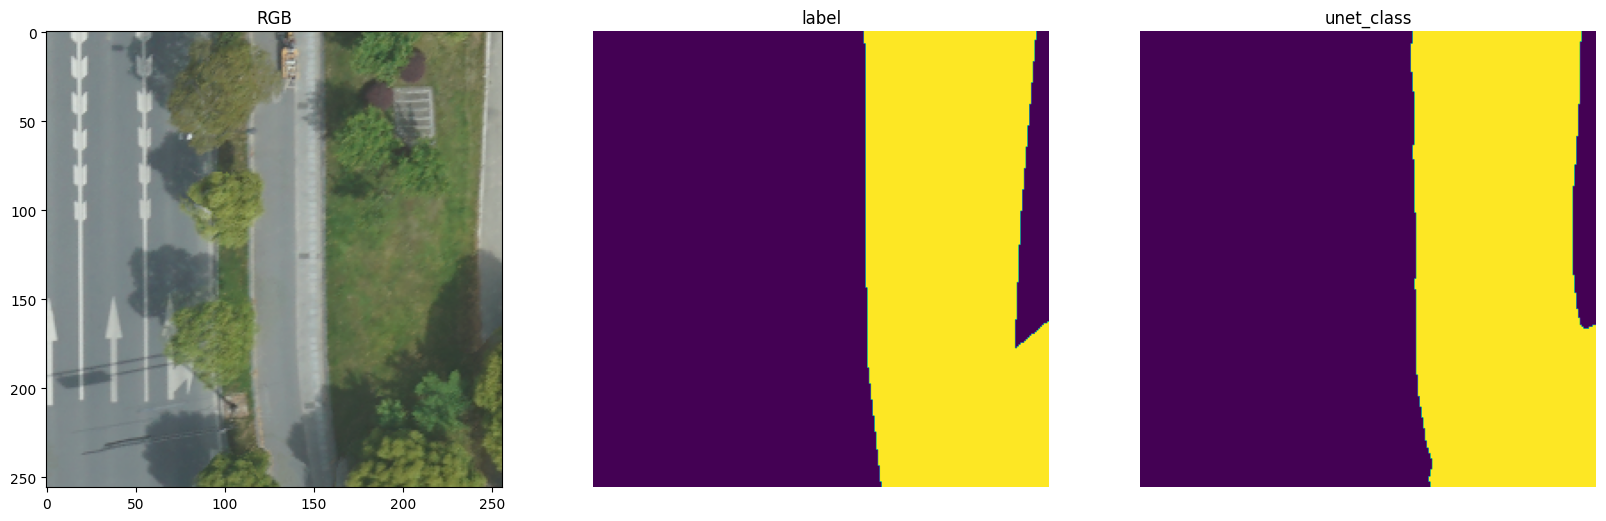

In [6]:
import matplotlib.pyplot as plt
import numpy as np
rgbImageDataset =  SegImageDataset("./dataset/rgb/","./dataset/label/")
rgbImage_loader = torch.utils.data.DataLoader(
    rgbImageDataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_classify(last_output):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type=="cuda":
        last_output = last_output.cpu().detach().numpy()
    else:
        last_output = last_output.detach().numpy()
    last_output[last_output>=0.5]=1
    last_output[last_output<0.5]=0
    return last_output
for i, (images, labels) in enumerate(rgbImage_loader):
    if i == 5:
        break
    images = images.to(device)
    labels = labels.to(device)
    unet_output = unet(images)

    unet_class = get_classify(unet_output)

    labels = labels.cpu().detach().numpy()
    for index in range(unet_class.shape[0]):
 
        plt.figure(figsize=(20,20))
        ax=plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(images.cpu().detach()[index], (1,2,0)))# 把channel那一维放到最后
        ax.set_title("RGB")

        ax=plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(labels[index], (1,2,0)))# 把channel那一维放到最后
        plt.axis('off')
        ax.set_title("label")
        
        ax=plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(unet_class[index], (1,2,0)))# 把channel那一维放到最后
        plt.axis('off')
        ax.set_title("unet_class")
    plt.show()